# DS 5100 Group Project
## Enron Email Text Analysis
### Michael Henry, Anura Ranasinghe, Ben Wilson

In [2]:
#import library
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime 
import matplotlib.pyplot as plt
import unittest
import nltk
from nltk.tokenize import word_tokenize
import string as str
import networkx as nx
from pyvis.network import Network
import pyvis
#nltk.download('stopwords')

/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Functions

In [3]:
#Create function to extract username portion of email
def extract_username(email):
    
    start = email.find("'")
    start += 1
    end = email.find("@")
    
    email_final = email[start:end]
    
    return email_final

In [4]:
def get_most_common_word(input_df, stop_words = None):
    """A function that takes a dataframe containing email data and finds the most common word per person and timeframe
    
    Input: df - a dataframe containing the columns Date, From, and content
    stop_words - words to be added to the nltk.corpus.stopwords.words list
    
    Output: a dataframe containing the original data and and a frequency distribution and top word"""
    df = input_df.copy()
    #Drop any NA values as they will pose a problem later
    df.drop(df.index[df.From.isna()], inplace = True)
    #Create a new column with a corpus of each person's emails
    df["corpus"] = df.groupby([df.Date.dt.year, df.From])["content"].transform(lambda x: ' '.join(x))
    #Save the date column on the same level of granualarity
    df.Date = df.Date.dt.year
    #Subset the relevant columns
    df = df[["Date", "From", "corpus"]]
    #Drop the duplicates otherwise the counts will repeat for each email that was passed
    df.drop_duplicates(inplace = True)
    #Tokenize the words
    df["Token"] = df.corpus.apply(word_tokenize)
    #create stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    #add own custom stop words
    if stop_words is not None:
        stopwords = stopwords + stop_words
    #Create a frequency distribution
    df["Freq_Dist"] = df.Token.apply(lambda x: nltk.FreqDist(w for w in x if w not in stopwords))
    #Get the top word from the frequency distribution
    df["Top_word"] = df.Freq_Dist.apply(lambda x: x.most_common(1)[0])
    df.reset_index(drop = True, inplace = True)
    return df[["From","Date","Top_word"]]

In [5]:
class Test_Most_Common(unittest.TestCase):
    """Unit test for the most common word function. The function should take a dataframe conatining emails, a date, and the sender and
    return the most common by sender by time period."""

    input_1 = pd.DataFrame({"From":["Tim","Tim","Tim","Ryan","Ryan","Ryan"],
                                "Date":pd.to_datetime(["2002-01-01","2002-03-04","2002-05-06",
                                                       "2003-04-12","2003-06-07","2003-06-05"], infer_datetime_format=True) ,
                               "content":["thanks for the email","let us circle back, thanks","thanks, that meeting was awesome",
                                          "we need to talk offline","when is the meeting", "that was the best meeting"]})
    expected_1 = pd.DataFrame({"From":["Tim","Ryan"],
                                 "Date":pd.to_datetime(["2002","2003"], infer_datetime_format = True).year,
                                  "Top_word":[("thanks",3), ("meeting", 2)]})

    input_2 = pd.DataFrame({"From":["Tim","Tim","Tim","Ryan","Ryan","Ryan"],
                                "Date":pd.to_datetime(["2002-01-01","2002-03-04","2002-05-06",
                                                       "2003-04-12","2003-06-07","2003-06-05"], infer_datetime_format=True) ,
                               "content":["thanks for the email","let us circle back, thanks","thanks, i will send another email",
                                          "we need to talk offline","when is the meeting", "that was the best meeting"]})

    expected_2 = pd.DataFrame({"From":["Tim","Ryan"],
                                 "Date":pd.to_datetime(["2002","2003"], infer_datetime_format = True).year,
                                  "Top_word":[("email",2), ("meeting", 2)]})


    #Test to make sure that the function correctly counts words while ignoring stop words
    def test_1_most_common(self):
        self.assertTrue(self.expected_1.equals(get_most_common_word(self.input_1)))
    #Test to make sure the function ignores our custom stopword list
    def test_2_add_stop_words(self):
        self.assertTrue(self.expected_2.equals(get_most_common_word(self.input_2, stop_words = ["thanks"])))  

In [6]:
class username_extract_test(unittest.TestCase): 
    
    email_text = "njgks!3d'sar2jf@virginia.edu'dfd"
    username = extract_username(email_text)
 
    def test_1(self):
           
        self.assertEqual('sar2jf',self.username)     
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False) 

...
----------------------------------------------------------------------
Ran 3 tests in 0.033s

OK


## 1.0 - Data Processing

## 1.1 Load All Data, Append DFs & Reduce Features

In [34]:
#subset of columns from data to import
column_subset = ["Date", "content", "From", "To"]

#import dataframes
df1 = pd.read_csv('https://query.data.world/s/3yohyk6lcu6fqchxjswbnzmei4hbs7', usecols = column_subset)
df2 = pd.read_csv('https://query.data.world/s/lpghc2knowlyifkf45xo6n2mvcmphc', usecols = column_subset)
df3 = pd.read_csv('https://query.data.world/s/j3ub5wm22ss34zkcxsa47ddnrx6i72', usecols = column_subset)
df4 = pd.read_csv('https://query.data.world/s/uanbfgie5rlphkmbdzv4chot4p5uat', usecols = column_subset)
df5 = pd.read_csv('https://query.data.world/s/6c2udzplebwtnot7iwtwuy77ztgkva', usecols = column_subset)
df6 = pd.read_csv('https://query.data.world/s/o47cjp4n6ojgm5rkvrqnrmrwecaljz', usecols = column_subset)
df7 = pd.read_csv('https://query.data.world/s/ps6zrcn5as7med6gmm7xqqh43hbe2y', usecols = column_subset)

#concatenate them together
Enron_df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
Enron_df.head()

,Date,From,To,content
0,2001-05-14 23:39:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),Here is our forecast
1,2001-05-04 20:51:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Traveling to have a business meeting takes the...
2,2000-10-18 10:00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),test successful. way to go!!!
3,2000-10-23 13:13:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),"Randy, Can you send me a schedule of the salar..."
4,2000-08-31 12:07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Let's shoot for Tuesday at 11:45.


## 1.2 - Basic Filtering

In [42]:
#drop NAs from data
Enron_df.dropna(inplace = True)
Enron_df.isna().sum()

Date       0
From       0
To         0
content    0
dtype: int64

In [43]:
#filter dates for emails between 1998 and 2007
Enron_df = Enron_df.loc[(Enron_df['Date'] >= '1998-01-12')
                     & (Enron_df['Date'] < '2007-12-31')]
Enron_df.dtypes

Date       object
From       object
To         object
content    object
dtype: object

In [44]:
#Apply function to both To / From columns
Enron_df['To'] = Enron_df['To'].apply(extract_username)
Enron_df['From'] = Enron_df['From'].apply(extract_username)

/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
Enron_df.head()

,Date,From,To,content
0,2001-05-14 23:39:00,phillip.allen,tim.belden,Here is our forecast
1,2001-05-04 20:51:00,phillip.allen,john.lavorato,Traveling to have a business meeting takes the...
2,2000-10-18 10:00:00,phillip.allen,leah.arsdall,test successful. way to go!!!
3,2000-10-23 13:13:00,phillip.allen,randall.gay,"Randy, Can you send me a schedule of the salar..."
4,2000-08-31 12:07:00,phillip.allen,greg.piper,Let's shoot for Tuesday at 11:45.


In [46]:
#Removing punctuation and lowering all characters
Enron_df.content = Enron_df.content.str.replace('[^A-Za-z]', ' ', regex = True)
Enron_df.content = Enron_df.content.str.lower()

#Remove "<" Symbols from Data
Enron_df = Enron_df[Enron_df["To"].str.contains('<')==False]
Enron_df = Enron_df[Enron_df["From"].str.contains('<')==False]

#Remove emails to oneself
Enron_df = Enron_df[Enron_df['From'] != Enron_df['To']]

#Remove emails to / from enron.announcements
Enron_df = Enron_df[Enron_df['From'] != 'enron.announcements']
Enron_df = Enron_df[Enron_df['To'] != 'enron.announcements']

/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
#convert date series to datetime format
Enron_df['Date'] = pd.to_datetime(Enron_df['Date'], infer_datetime_format=True)
Enron_df.dtypes

Date       datetime64[ns]
From               object
To                 object
content            object
dtype: object

## 1.3 EDA of DF

/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, '# of Emails by Time of Day')

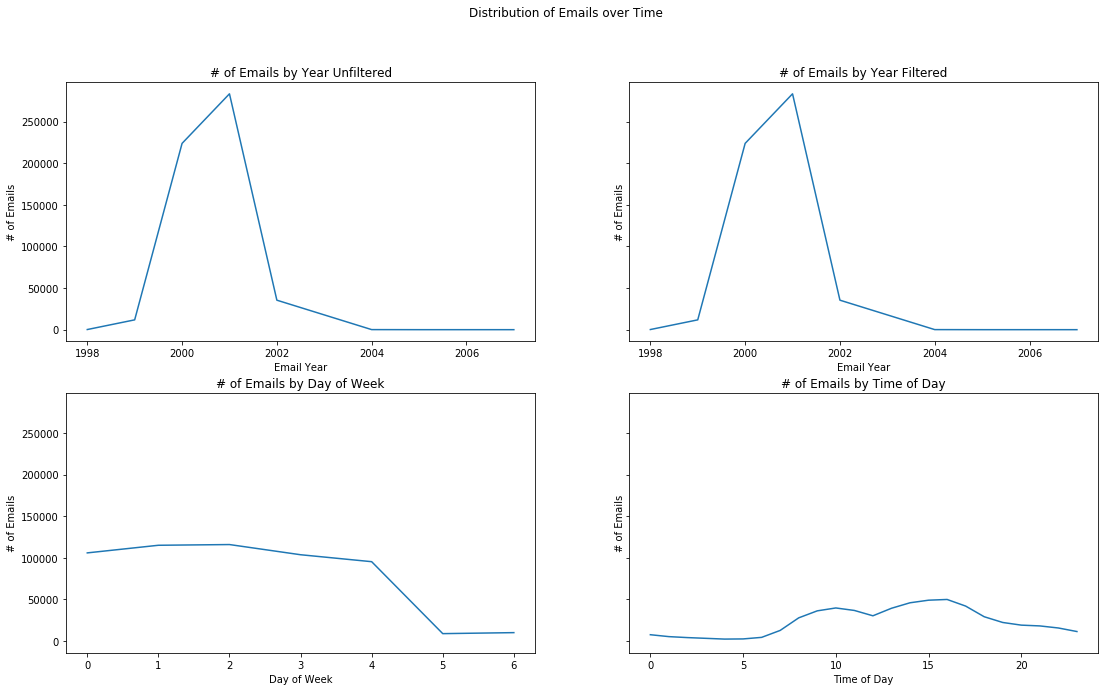

In [49]:
#visual of emails sent by year
fig, axs = plt.subplots(2,2, sharey = True)
fig.suptitle("Distribution of Emails over Time")
fig.set_size_inches(18.5, 10.5)
axs[0,0].plot(sorted(Enron_df.Date.dt.year.unique()), Enron_df.groupby(Enron_df['Date'].dt.year)['content'].count())
axs[0,0].set_xlabel('Email Year')
axs[0,0].set_ylabel('# of Emails')
axs[0,0].set_title('# of Emails by Year Unfiltered')
#visual of emails sent by year
axs[0,1].plot(sorted(Enron_df.Date.dt.year.unique()), Enron_df.groupby(Enron_df['Date'].dt.year)['content'].count())
axs[0,1].set_xlabel('Email Year')
axs[0,1].set_ylabel('# of Emails')
axs[0,1].set_title('# of Emails by Year Filtered')
axs[1,0].plot(sorted(Enron_df.Date.dt.dayofweek.unique()), Enron_df.groupby(Enron_df['Date'].dt.dayofweek)['content'].count())
axs[1,0].set_xlabel('Day of Week')
axs[1,0].set_ylabel('# of Emails')
axs[1,0].set_title('# of Emails by Day of Week')
axs[1,1].plot(sorted(Enron_df.Date.dt.hour.unique()), Enron_df.groupby(Enron_df['Date'].dt.hour)['content'].count())
axs[1,1].set_xlabel('Time of Day')
axs[1,1].set_ylabel('# of Emails')
axs[1,1].set_title('# of Emails by Time of Day')

In [50]:
#determine top email distributors by From
EE_Email_Sent = pd.DataFrame(Enron_df['From'].value_counts()[:10])
EE_Email_Sent.reset_index(inplace=True)
EE_Email_Sent.columns = ["Email From", "Count"]
EE_Email_Sent

,Email From,Count
0,jeff.dasovich,20583
1,kay.mann,16593
2,vince.kaminski,14045
3,eric.bass,9959
4,sara.shackleton,8698
5,chris.germany,8584
6,sally.beck,8536
7,tana.jones,8417
8,john.arnold,6825
9,steven.kean,6285


[Text(0, 0, 'jeff.dasovich'),
 Text(0, 0, 'kay.mann'),
 Text(0, 0, 'vince.kaminski'),
 Text(0, 0, 'eric.bass'),
 Text(0, 0, 'sara.shackleton'),
 Text(0, 0, 'chris.germany'),
 Text(0, 0, 'sally.beck'),
 Text(0, 0, 'tana.jones'),
 Text(0, 0, 'john.arnold'),
 Text(0, 0, 'steven.kean')]

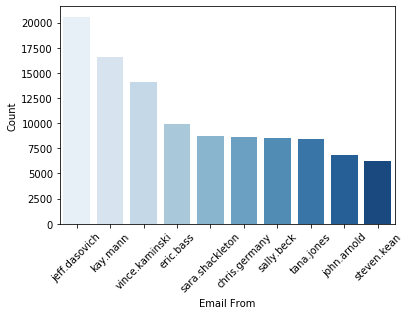

In [51]:
#view bar plot by top from emailers
barplot = sns.barplot(x = "Email From", y = "Count", data = EE_Email_Sent, palette = "Blues")

barplot.set_xticklabels(barplot.get_xticklabels(), rotation = 45)

# 2.0 - High Frequency Email Distribution

In [52]:
#Create initial dataframe required to make heatmap
dist_freq_df = Enron_df[['From', 'To']]
dist_freq_df = dist_freq_df.dropna()

dist_freq_df.head()

,From,To
0,phillip.allen,tim.belden
1,phillip.allen,john.lavorato
2,phillip.allen,leah.arsdall
3,phillip.allen,randall.gay
4,phillip.allen,greg.piper


## 2.2 - Frequency Distribution Table

In [53]:
dist_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554562 entries, 0 to 17400
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   From    554562 non-null  object
 1   To      554562 non-null  object
dtypes: object(2)
memory usage: 12.7+ MB


In [54]:
#Aggregate emails by From / To Column
dist_freq_df['Count'] = 1
dist_freq_df_agg = dist_freq_df.groupby(['From', 'To'], as_index=False).agg({'Count':['sum']})
dist_freq_df_agg.columns = ['From', 'To', 'Count']

In [55]:
#Frequency Distribution Table
dist_freq_df_agg = dist_freq_df_agg.sort_values(by = 'Count', ascending = False).head(500)
dist_freq_df_agg.head(50)

,From,To,Count
70813,vince.kaminski,vkaminski,4197
35554,kay.mann,suzanne.adams,1530
28881,jeff.dasovich,susan.mara,1520
28521,jeff.dasovich,erika.dupre,1402
70744,vince.kaminski,shirley.crenshaw,1195
28555,jeff.dasovich,harry.kingerski,1122
35459,kay.mann,nmann,1048
64479,steven.kean,maureen.mcvicker,1024
19680,eric.bass,shanna.husser,1007
48928,mjones7,daren.j.farmer,1002


# 3.0 - Most Common Word Usage

## 3.1 - Word Usage

In [16]:
#Create dataframes from the emails of different key people
#Ken Lay - original CEO
ken_lay_aliases = ["kenneth.lay","ken.lay-","ken.lay-.chairman.of.the.board"]
ken_lay_df = Enron_df[Enron_df.From.isin(ken_lay_aliases)]
ken_lay_df["From"] = "Kenneth Lay"

#Jeffrey Skilling - CEO during downfall
jeffrey_skilling_aliases = ["ken.skilling", "jeff.skilling", "jeffreyskilling"]
jeffrey_skilling_df = Enron_df[Enron_df.From.isin(jeffrey_skilling_aliases)]
jeffrey_skilling_df["From"] = "Jeffrey Skilling"

#Sara Shackelton - Legal General Counsel Assistant
sara_shackleton_df = Enron_df[Enron_df.From == "sara.shackleton"]

#Jeff Dasovich - Director for State Government Affairs
jeff_dasovich_df = Enron_df[Enron_df.From == "jeff.dasovich"]

#Sally Beck - COO
sally_beck_df = Enron_df[Enron_df.From == "sally.beck"]

#Eric Bass - Energy Trader
eric_bass_df = Enron_df[Enron_df.From == "eric.bass"]

/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mikehenry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [22]:
ken = get_most_common_word(ken_lay_df[["Date", "From", "content"]], stop_words = ["enron", "lay", "ceo", "cindy", "jeff", "joe", "company"])
jeffrey = get_most_common_word(jeffrey_skilling_df[["Date", "From", "content"]], stop_words = ["enron", "get", "mark", "one", "com", "business", "like", "hotmail"])
sara = get_most_common_word(sara_shackleton_df[["Date", "From", "content"]], stop_words = ["enron", "sara", "shackleton", "sent", "subject", "message", "original"])
eric = get_most_common_word(eric_bass_df[["Date", "From", "content"]], stop_words = ["enron", "eric", "bass", "sent", "subject", "com", "ect"])
jeff = get_most_common_word(jeff_dasovich_df[["Date", "From", "content"]], stop_words = ["enron", "jeff", "dasovich", "sent", "subject", "com", "e"])
sally = get_most_common_word(sally_beck_df[["Date", "From", "content"]], stop_words = ["enron", "sally", "beck", "sent", "subject", "com", "ect", "hou", "enronxgate", "pm"])

,From,Date,Top_word
0,jeff.dasovich,2000,"(ees, 14410)"
1,jeff.dasovich,2001,"(mail, 38266)"
2,jeff.dasovich,1999,"(energy, 52)"
3,jeff.dasovich,2002,"(budget, 62)"


In [25]:
top_words = pd.concat([ken, jeffrey, sally, jeff, eric, sara])
top_words.sort_values("Date")

,From,Date,Top_word
3,sara.shackleton,1999,"(ect, 7519)"
2,Jeffrey Skilling,1999,"(vendors, 10)"
2,eric.bass,1999,"(hou, 2368)"
2,sally.beck,1999,"(open, 318)"
2,jeff.dasovich,1999,"(energy, 52)"
1,Kenneth Lay,2000,"(hr, 16)"
0,Jeffrey Skilling,2000,"(services, 300)"
0,sally.beck,2000,"(corp, 5394)"
1,eric.bass,2000,"(hou, 21402)"
0,jeff.dasovich,2000,"(ees, 14410)"


# 4.0 - Enron Email Network

## 4.1 - Network for high frequency email distributors in Enron

In [26]:
#establish network variable for visualization
G = nx.from_pandas_edgelist(mi_df, source = 'From', target = 'To')

In [27]:
#visualize network
net = Network(notebook = True)
net.from_nx(G)
net.show("enron_test.html")